# run data


In [1]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numba as nb
import numpy as np
import os
import matplotlib.animation as ma
import seaborn as sns
from AdaptiveInteraction import AdaptiveInteraction2D
from AdaptiveInteraction import StateAnalysis


In [ ]:
N = 100
r_c = 0.5
range_K = np.linspace(0,1,6)
range_J = np.linspace(0,1,6)

models = []
for K in range_K:
    for J in range_J:
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        models.append(model)

from multiprocessing import Pool

def run_model(model):
    model.run(5000)

with Pool(14) as p:
    p.map(run_model, tqdm(models, total=len(models)))

In [ ]:
N = 200
K = 0.5
range_r_c = np.linspace(-1,-0.1,10)
range_J = np.linspace(-1,-0.1,10)

for r_c in range_r_c:
    for J in range_J:
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.1, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        model.run(5000)


# Final States

In [ ]:
import seaborn as sns

sns.set_theme(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

N = 100
K= 5
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

fig = plt.figure(figsize=(len(range_r_c) * 3, len(range_J) * 3)) 

idx = 1

for J in range_J:#纵轴
    for r_c in range_r_c:#横轴
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        sa = StateAnalysis(model, lookIndex=-1)
        index = -1
        positionX = sa.totalPositionX[index]
        phaseTheta = sa.totalPhaseTheta[index]   
        pointX = sa.totalPointX[index]
        pointTheta = sa.totalPointTheta[index]

        ax = plt.subplot(len(range_r_c), len(range_J), idx)  # 顺序
        maxAbsPos = np.max(np.abs(positionX)) 

        dx = pointX[:, 0]
        dy = pointX[:, 1]

        magnitudes = np.sqrt(dx**2 + dy**2)

        magnitudes[magnitudes == 0] = 1

        dx_normalized = dx / magnitudes
        dy_normalized = dy / magnitudes

        fixed_length = 0.1
        dx_fixed = dx_normalized * fixed_length
        dy_fixed = dy_normalized * fixed_length

        qv = ax.quiver(positionX[:, 0], positionX[:, 1], dx_fixed, dy_fixed, 
                       phaseTheta, cmap='viridis', clim=(0, 2*np.pi))

        ax.set_xlim(-1.1*maxAbsPos, 1.1*maxAbsPos)
        ax.set_ylim(-1.1*maxAbsPos, 1.1*maxAbsPos)
        ax.set_title(f"$\ J={J:.1f},\ r_c ={r_c:.1f},$")

        idx += 1

plt.tight_layout()
if not os.path.exists("./biGraph"):
    os.makedirs("./biGraph")
plt.savefig(f"./biGraph/FinalStates_K={K}.png", dpi=200, bbox_inches="tight")
plt.close()

In [ ]:
N = 100
K= 1
r_c = 0.1
J = 0.1

fig = plt.figure(figsize=(len(range_r_c) * 3, len(range_J) * 3)) 

idx = 1

model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
sa = StateAnalysis(model, lookIndex=-1)
index = -1
positionX = sa.totalPositionX[index]
phaseTheta = sa.totalPhaseTheta[index]   
pointX = sa.totalPointX[index]
pointTheta = sa.totalPointTheta[index]
# Calculate dx and dy for the arrows
dx = pointX[:, 0]
dy = pointX[:, 1]

# Calculate the magnitude of each vector
magnitudes = np.sqrt(dx**2 + dy**2)

# Avoid division by zero
magnitudes[magnitudes == 0] = 1

# Normalize dx and dy
dx_normalized = dx / magnitudes
dy_normalized = dy / magnitudes

# Set a fixed length for all arrows (e.g., 0.1 units)
fixed_length = 0.1
dx_fixed = dx_normalized * fixed_length
dy_fixed = dy_normalized * fixed_length
ax = plt.subplot(len(range_r_c), len(range_J), idx)  # 顺序
maxAbsPos = np.max(np.abs(positionX)) 
qv = ax.quiver(positionX[:, 0], positionX[:, 1], dx_fixed, dy_fixed, 
               phaseTheta, cmap='viridis', clim=(0, 2*np.pi))

cbar = plt.colorbar(qv, ax=ax)
cbar.set_ticks([0, np.pi, 2*np.pi])

ax.set_xlim(-1.1*maxAbsPos, 1.1*maxAbsPos)
ax.set_ylim(-1.1*maxAbsPos, 1.1*maxAbsPos)
ax.set_title(f"$\ J={J:.1f},\ r_c ={r_c:.1f},$")


# order parameter

## S

In [ ]:
N = 100
K= 1
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)
S_values = pd.DataFrame(index=range_J, columns=range_r_c)



for i, r_c in enumerate(range_r_c): 
    for j, J in enumerate(range_J):
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")

        targetPath = f"./data/{model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        TNum = totalPositionX.shape[0] // model.agentsNum

        totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
        transient_index = int(0.9*totalPositionX.shape[0])
        totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
        totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
        totalPhaseTheta = totalPhaseTheta.values.reshape(
            TNum, model.agentsNum)[transient_index:-1]

        num_osc = len(totalPosition_x)

        phi = np.arctan2(totalPosition_y, totalPosition_x)
        W_plus = np.exp(1j*(phi + totalPhaseTheta))
        W_minus = np.exp(1j*(phi - totalPhaseTheta))
        
        time_OP_plus = np.abs(W_plus.mean(axis=1))
        time_OP_minus = np.abs(W_minus.mean(axis=1))
        S_plus = time_OP_plus.mean()
        S_minus = time_OP_minus.mean()

        S = max(S_plus, S_minus)

        S_values.loc[J, r_c] = S

In [2]:
def cal_S_matrix(N, K, range_r_c, range_J, savePath):
    S_values = pd.DataFrame(index=range_J, columns=range_r_c)

    for i, r_c in enumerate(range_r_c): 
        for j, J in enumerate(range_J):
            model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")

            targetPath = f"{savePath}/{model}.h5"
            totalPositionX = pd.read_hdf(targetPath, key="positionX")
            totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
            TNum = totalPositionX.shape[0] // model.agentsNum

            totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
            transient_index = int(0.9*totalPositionX.shape[0])
            totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
            totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
            totalPhaseTheta = totalPhaseTheta.values.reshape(
                TNum, model.agentsNum)[transient_index:-1]
            
            phi = np.arctan2(totalPosition_y, totalPosition_x)
            W_plus = np.exp(1j*(phi + totalPhaseTheta))
            W_minus = np.exp(1j*(phi - totalPhaseTheta))

            time_OP_plus = np.abs(W_plus.mean(axis=1))
            time_OP_minus = np.abs(W_minus.mean(axis=1))
            S_plus = time_OP_plus.mean()
            S_minus = time_OP_minus.mean()

            S = max(S_plus, S_minus)

            S_values.loc[J, r_c] = S
    return S_values

def plot_S_matrix(S_values, K):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(S_values, ax=ax, cmap="viridis", cbar_kws={'label': 'S'}, square=True)
    ax.set_title(f"$K={K}$")
    ax.set_xlabel("$r_c$")
    ax.set_ylabel("$J$")
    plt.tight_layout()
    plt.savefig(f"./biGraph/S_K={K}.png", dpi=200, bbox_inches="tight")
    plt.close()


In [3]:
N = 100
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

S1 = cal_S_matrix(N, 0.5, range_r_c, range_J, "data")
S2 = cal_S_matrix(N, 1, range_r_c, range_J, "data")
S3 = cal_S_matrix(N, 2, range_r_c, range_J, "data")
S4 = cal_S_matrix(N, 5, range_r_c, range_J, "data")



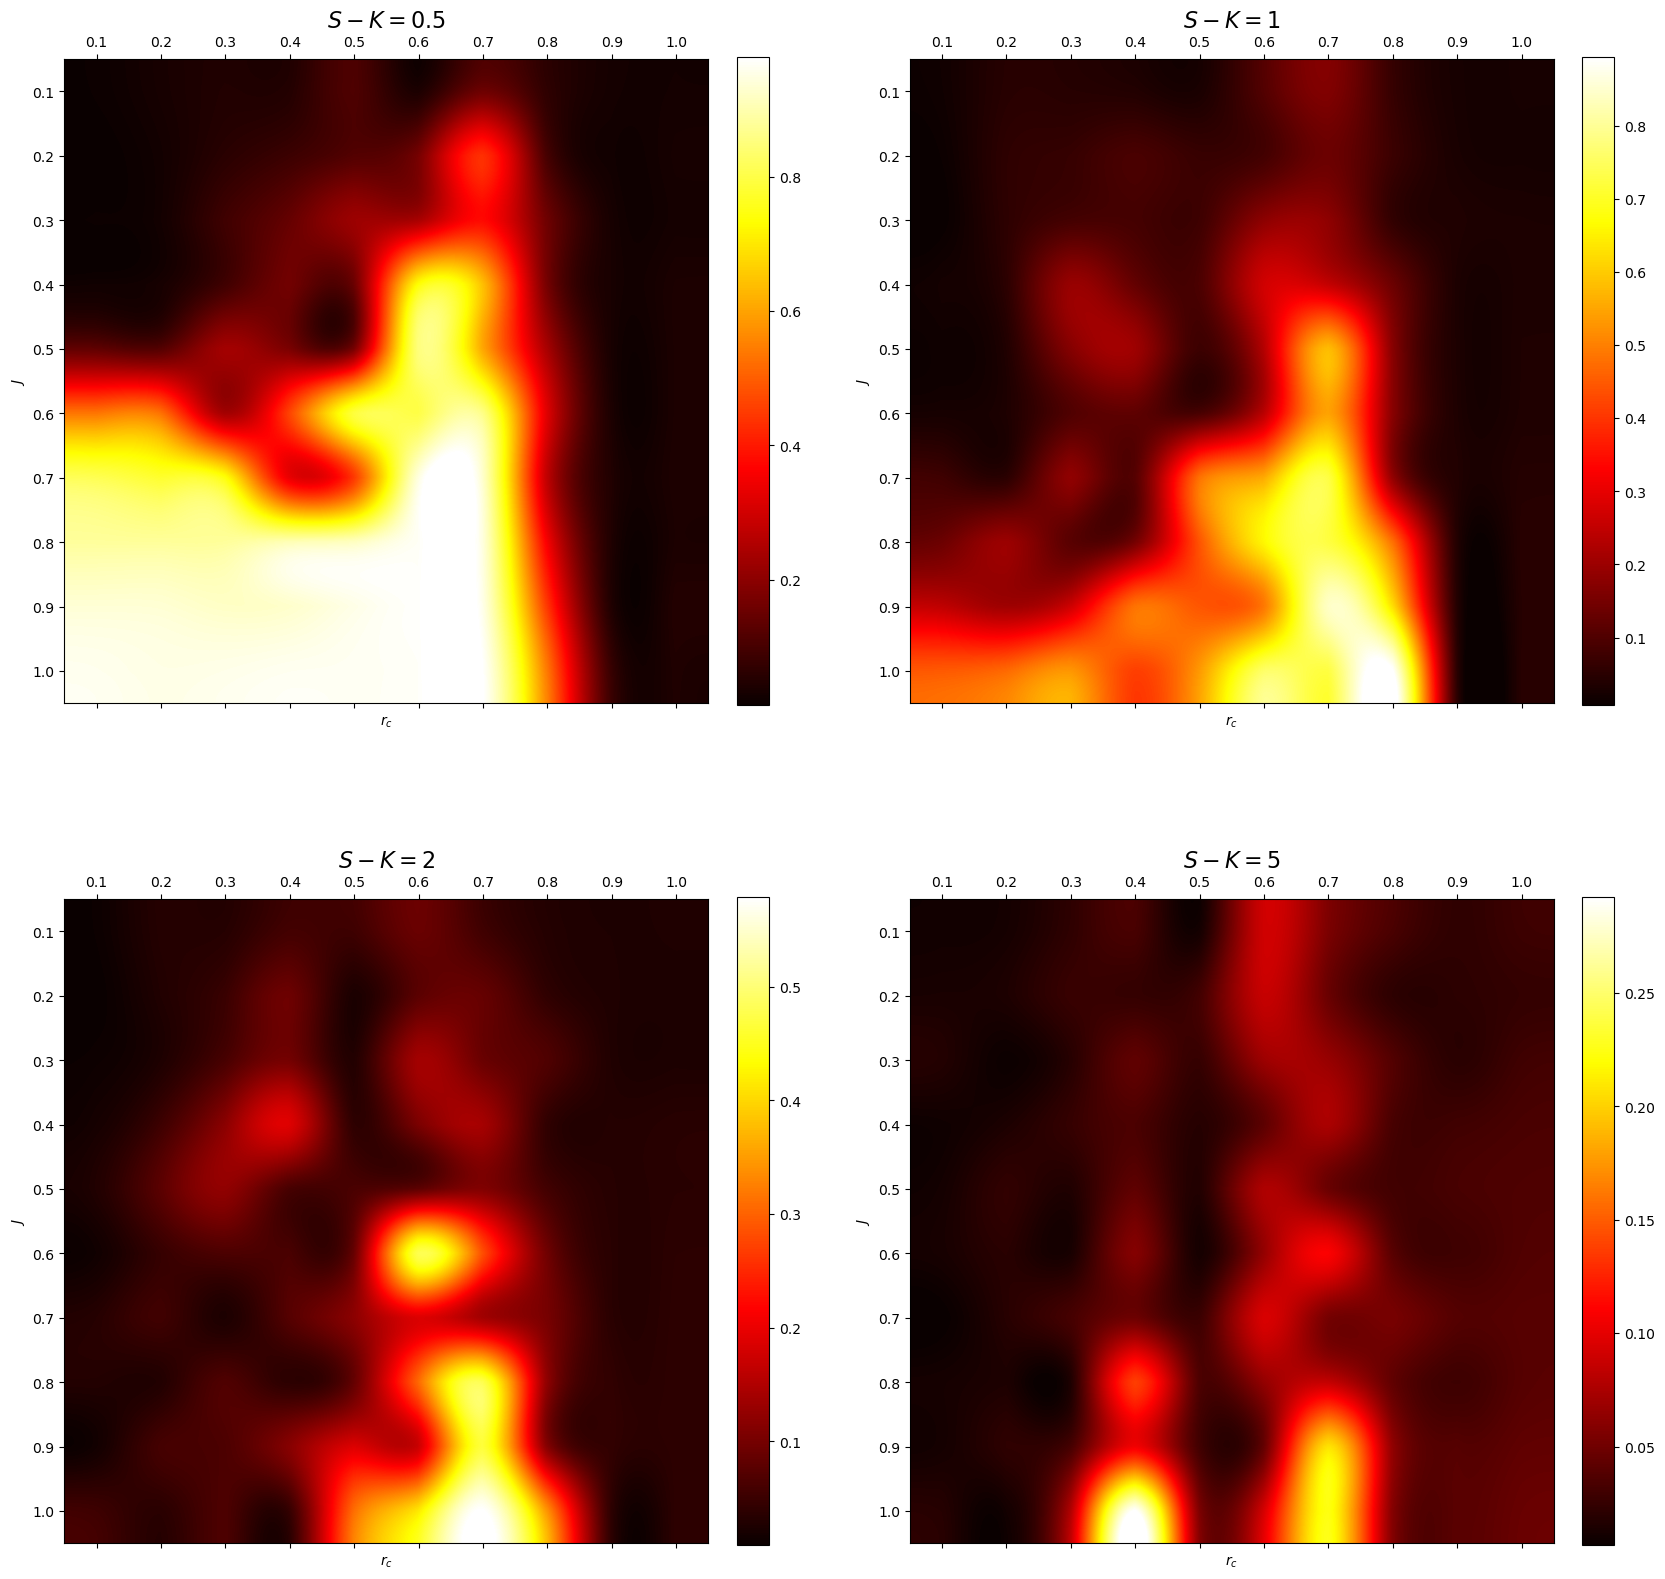

In [25]:
fig,axs = plt.subplots(2,2,figsize=(20,20))
S_values_numeric = S1.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
S_values_numeric = S_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax1 = axs[0,0].matshow(S_values_numeric, cmap='hot',interpolation='spline16')
axs[0,0].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[0,0].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[0,0].set_xlabel("$r_c$")
axs[0,0].set_ylabel("$J$")
axs[0,0].set_title(f"$S-K={0.5}$", fontsize=16)
fig.colorbar(ax1, ax=axs[0,0], fraction=0.046, pad=0.04)

S_values_numeric = S2.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
S_values_numeric = S_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax2 = axs[0,1].matshow(S_values_numeric, cmap='hot',interpolation='spline16')
axs[0,1].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[0,1].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[0,1].set_xlabel("$r_c$")
axs[0,1].set_ylabel("$J$")
axs[0,1].set_title(f"$S-K={1}$", fontsize=16)
fig.colorbar(ax2, ax=axs[0,1], fraction=0.046, pad=0.04)

S_values_numeric = S3.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
S_values_numeric = S_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax3 = axs[1,0].matshow(S_values_numeric, cmap='hot',interpolation='spline16')
axs[1,0].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[1,0].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[1,0].set_xlabel("$r_c$")
axs[1,0].set_ylabel("$J$")
axs[1,0].set_title(f"$S-K={2}$", fontsize=16)
fig.colorbar(ax3, ax=axs[1,0], fraction=0.046, pad=0.04)

S_values_numeric = S4.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
S_values_numeric = S_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax4 = axs[1,1].matshow(S_values_numeric, cmap='hot',interpolation='spline16')
axs[1,1].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[1,1].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[1,1].set_xlabel("$r_c$")
axs[1,1].set_ylabel("$J$")
axs[1,1].set_title(f"$S-K={5}$", fontsize=16)
fig.colorbar(ax4, ax=axs[1,1], fraction=0.046, pad=0.04)




In [ ]:
N = 100
K= 1
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

R_values = np.zeros((len(range_J), len(range_K)))

for i, r_c in enumerate(range_r_c):
    for j, J in enumerate(range_J):
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
        # model.run(2000)

        # 计算S的值
        targetPath = f"./data/{model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        TNum = totalPositionX.shape[0] // model.agentsNum

        totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
        transient_index = int(0.9*totalPositionX.shape[0])
        totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
        totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
        totalPhaseTheta = totalPhaseTheta.values.reshape(
            TNum, model.agentsNum)[transient_index:-1]
        

        R_time = np.exp(1j * phaseTheta)
        R = np.abs(np.mean(R_time, axis=1))
        R = np.mean(R)

        R_values[j, i] = R

# 绘制热图

# 设置图片尺寸（6，5）
fig = plt.figure(figsize=(8, 6))
plt.imshow(R_values, cmap='viridis', origin='lower',
           extent=[0, 1, 0, 1], interpolation='spline16') # imshow 读取数据的顺序
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
# plt.colorbar(label='S',ticks=[0, 0.5, 1])
plt.grid(False)
cbar = plt.colorbar(label='S', ticks=[0, 0.5, 1])
plt.clim(0, 1)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xlabel('r_c')
plt.ylabel('J')
plt.title('S')
plt.show()

In [ ]:
pd.DataFrame(R_values, index=range_J, columns=range_K)

## R

In [17]:
def cal_R_matrix(N, K, range_r_c, range_J, savePath):
    R_values = pd.DataFrame(index=range_J, columns=range_r_c)

    for i, r_c in enumerate(range_r_c): 
        for j, J in enumerate(range_J):
            model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")

            targetPath = f"{savePath}/{model}.h5"
            totalPositionX = pd.read_hdf(targetPath, key="positionX")
            totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
            TNum = totalPositionX.shape[0] // model.agentsNum

            totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
            transient_index = int(0.9*totalPositionX.shape[0])
            totalPhaseTheta = totalPhaseTheta.values.reshape(
                TNum, model.agentsNum)[transient_index:-1]
            
            Z = np.exp(1j*totalPhaseTheta)

            time_R = np.abs(Z.mean(axis=1))
            R = time_R.mean()

            R_values.loc[J, r_c] = R
    return R_values


In [21]:
N = 100
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)

R1 = cal_R_matrix(N, 0.5, range_r_c, range_J, "data")
R2 = cal_R_matrix(N, 1, range_r_c, range_J, "data")
R3 = cal_R_matrix(N, 2, range_r_c, range_J, "data")
R4 = cal_R_matrix(N, 5, range_r_c, range_J, "data")

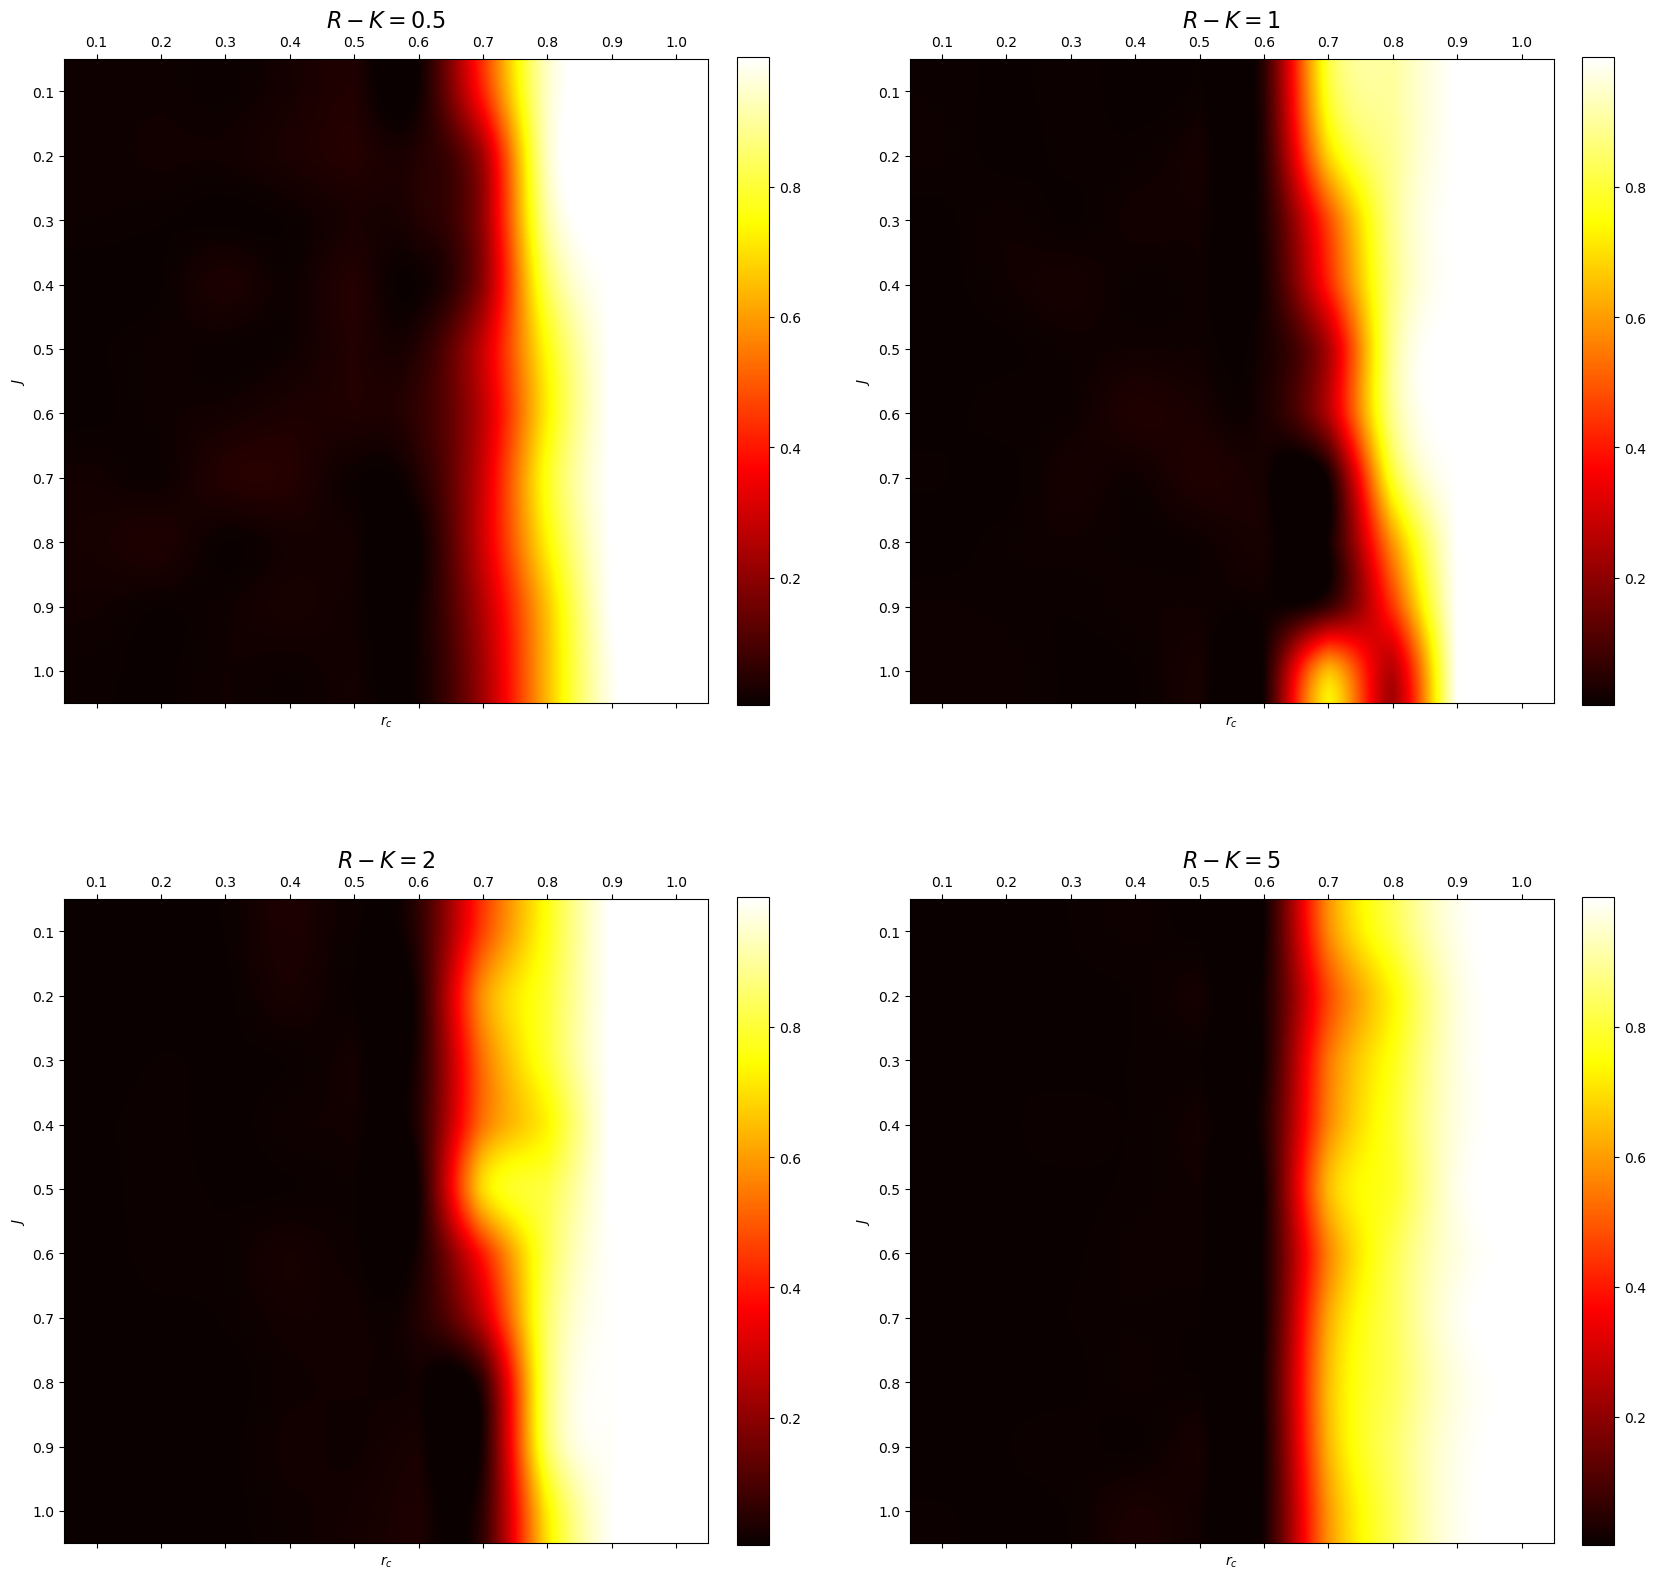

In [26]:
fig,axs = plt.subplots(2,2,figsize=(20,20))
R_values_numeric = R1.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
R_values_numeric = R_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax1 = axs[0,0].matshow(R_values_numeric, cmap='hot',interpolation='spline16')
axs[0,0].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[0,0].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[0,0].set_xlabel("$r_c$")
axs[0,0].set_ylabel("$J$")
axs[0,0].set_title(f"$R-K={0.5}$", fontsize=16)
fig.colorbar(ax1, ax=axs[0,0], fraction=0.046, pad=0.04)

R_values_numeric = R2.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
R_values_numeric = R_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax2 = axs[0,1].matshow(R_values_numeric, cmap='hot',interpolation='spline16')
axs[0,1].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[0,1].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[0,1].set_xlabel("$r_c$")
axs[0,1].set_ylabel("$J$")
axs[0,1].set_title(f"$R-K={1}$", fontsize=16)
fig.colorbar(ax2, ax=axs[0,1], fraction=0.046, pad=0.04)

R_values_numeric = R3.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
R_values_numeric = R_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax3 = axs[1,0].matshow(R_values_numeric, cmap='hot',interpolation='spline16')
axs[1,0].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[1,0].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[1,0].set_xlabel("$r_c$")
axs[1,0].set_ylabel("$J$")
axs[1,0].set_title(f"$R-K={2}$", fontsize=16)
fig.colorbar(ax3, ax=axs[1,0], fraction=0.046, pad=0.04)

R_values_numeric = R4.apply(pd.to_numeric, errors='coerce',)  # Convert non-numeric to NaN
R_values_numeric = R_values_numeric.fillna(0)  # Optional: Replace NaN with 0
ax4 = axs[1,1].matshow(R_values_numeric, cmap='hot',interpolation='spline16')
axs[1,1].set_xticks(np.arange(len(range_r_c)), range_r_c.round(2))
axs[1,1].set_yticks(np.arange(len(range_J)), range_J.round(2))
axs[1,1].set_xlabel("$r_c$")
axs[1,1].set_ylabel("$J$")
axs[1,1].set_title(f"$R-K={5}$", fontsize=16)
fig.colorbar(ax4, ax=axs[1,1], fraction=0.046, pad=0.04)



## $V_p$

In [ ]:
N = 100
K= 1
range_r_c = np.linspace(0.1,1,10)
range_J = np.linspace(0.1,1,10)
S_values = pd.DataFrame(index=range_J, columns=range_r_c)



for i, r_c in enumerate(range_r_c): 
    for j, J in enumerate(range_J):
        model = AdaptiveInteraction2D(agentsNum=N, dt=0.01, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")

        targetPath = f"./data/{model}.h5"
        totalPositionX = pd.read_hdf(targetPath, key="positionX")
        totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
        TNum = totalPositionX.shape[0] // model.agentsNum

        totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
        transient_index = int(0.9*totalPositionX.shape[0])
        totalPosition_x = totalPositionX[:, :, 0][transient_index:-1]
        totalPosition_y = totalPositionX[:, :, 1][transient_index:-1]
        totalPhaseTheta = totalPhaseTheta.values.reshape(
            TNum, model.agentsNum)[transient_index:-1]

        num_osc = len(totalPosition_x)

        phi = np.arctan2(totalPosition_y, totalPosition_x)
        W_plus = np.exp(1j*(phi + totalPhaseTheta))
        W_minus = np.exp(1j*(phi - totalPhaseTheta))
        
        time_OP_plus = np.abs(W_plus.mean(axis=1))
        time_OP_minus = np.abs(W_minus.mean(axis=1))
        S_plus = time_OP_plus.mean()
        S_minus = time_OP_minus.mean()

        S = max(S_plus, S_minus)

        S_values.loc[J, r_c] = S

# animation

In [11]:
J = 1
K = 0.5
r_c = 0.8
N = 200
model = AdaptiveInteraction2D(agentsNum=N, dt=0.1, J=J, K = K, r_c=r_c, tqdm=True, savePath="data")
model.run(5000)
# model.plot()

  0%|          | 0/5000 [00:00<?, ?it/s]

c:\Users\11393\OneDrive\Documents\SwarmalatorExperience\AdaptiveInteranction2D\AdaptiveInteraction.py:98: RuntimeWarning: invalid value encountered in divide
  answer = numerator / self.temp["distanceX2"] ** power
c:\Users\11393\OneDrive\Documents\SwarmalatorExperience\AdaptiveInteranction2D\AdaptiveInteraction.py:100: RuntimeWarning: divide by zero encountered in divide
  answer = numerator / self.temp["distanceX"] ** power
c:\Users\11393\OneDrive\Documents\SwarmalatorExperience\AdaptiveInteranction2D\AdaptiveInteraction.py:98: RuntimeWarning: invalid value encountered in divide
  answer = numerator / self.temp["distanceX2"] ** power
c:\Users\11393\OneDrive\Documents\SwarmalatorExperience\AdaptiveInteranction2D\AdaptiveInteraction.py:100: RuntimeWarning: divide by zero encountered in divide
  answer = numerator / self.temp["distanceX"] ** power


In [9]:
def draw_mp4(model, savePath: str = "./data", mp4Path: str = "./mp4",step: int = 1):
    
    targetPath = f"{savePath}/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointX = pd.read_hdf(targetPath, key="pointX")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum,2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointX = totalPointX.values.reshape(TNum, model.agentsNum,2)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    maxAbsPos = np.max(np.abs(totalPositionX)) 

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        pointX = totalPointX[i]
        pointTheta = totalPointTheta[i]
        fig.clear() # Clear the previous frame
        ax1 = plt.subplot(1, 1, 1)

        dx = pointX[:, 0]
        dy = pointX[:, 1]

        magnitudes = np.sqrt(dx**2 + dy**2)

        magnitudes[magnitudes == 0] = 1

        dx_normalized = dx / magnitudes
        dy_normalized = dy / magnitudes

        fixed_length = 0.1
        dx_fixed = dx_normalized * fixed_length
        dy_fixed = dy_normalized * fixed_length

        qv = ax1.quiver(positionX[:, 0], positionX[:, 1], dx_fixed, dy_fixed, 
                       phaseTheta, cmap='viridis', clim=(0, 2*np.pi))

        qv.set_clim(0, 2*np.pi)# 设置颜色映射的范围

        # ax1.quiver(positionX[:, 0], positionX[:, 1], pointX[:,0], pointX[:, 1],
        #                 phaseTheta,cmap='viridis', clim=(0, 2*np.pi))
        # ax1.scatter(positionX[:,0], positionX[:,1], c=phaseTheta, cmap=new_cmap, alpha=0.8, vmin=0, vmax=2*np.pi,s=10) # 点的大小用参数s控制，默认是20
        ax1.set_xlim(-1.1*maxAbsPos, 1.1*maxAbsPos) 
        ax1.set_ylim(-1.1*maxAbsPos, 1.1*maxAbsPos) 
        roundBound = np.round(maxAbsPos) # 四舍五入
        ax1.set_xticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound]) # 设置x轴刻度
        ax1.set_yticks([-roundBound, -roundBound / 2, 0, roundBound / 2, roundBound])   # 设置y轴刻度

    frames = np.arange(0, TNum, step) # 生成帧数
    pbar = tqdm(total=len(frames))
    fig, ax = plt.subplots(figsize=(5, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=frames, interval=50, repeat=False)# 如何倍速播放，interval=50表示每50ms更新一次，想快点就设置小一点
    # 判断是否存在mp4文件夹，不存在则创建
    if not os.path.exists(mp4Path):
        os.makedirs(mp4Path)
    ani.save(f"{mp4Path}/{model}.mp4", dpi=200) # dpi是分辨率
    plt.close()

    pbar.close()


In [12]:
draw_mp4(model)

  0%|          | 0/1001 [00:00<?, ?it/s]

d:\ProgramData\anaconda3\Lib\site-packages\matplotlib\quiver.py:627: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
d:\ProgramData\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
